- How to develop an adhesin and adhesin-like proteins predictor model with tensorflow-keras package in python to discover new unseen adhesin eucaryotic proteins. 


This model is inspired by SPAAN (https://pubmed.ncbi.nlm.nih.gov/15374866/, SPAAN: a software program for prediction of adhesins and adhesin-like proteins using neural networks). In the wake of this first adhesins model, more similar models has emerged like fungalRV, FaaPred (fungal adhesins) and MAAP (malarial adhesins). Downside of these models lies in the negative dataset creation, consisting of only internal/cytoplasmatic proteins. In order to achieve better performance and limit the number of false positives euSPAAN uses a negative dataset which includes internal proteins and external ones not having adhesion properties. 

Positive dataset was created through a study of the available literature, searching for domains that caracterize adhesins proteins in eukarya domain. Domains were collected as PFAM domains and searched for using Interpro database (https://www.ebi.ac.uk/interpro/), collecting only eucaryotic proteins containing adhesion domains.

Like previous times, resulting proteins of positive and negative classes were clusterized using cd-hit (30% homology similarity limit).

1. Data mining:


In [ ]:
%%capture
!pip install Biopython
!git clone https://github.com/Superzchen/iFeature

import numpy as np
import tensorflow
from tensorflow import keras
import matplotlib.pyplot as plt
from Bio import SeqIO
from random import sample
import random

np.random.seed(42)

In [ ]:
#!pip install wandb

In [ ]:
#import wandb
#wandb.init(project="uncategorized")

In [ ]:
file = open("negative.fasta")
n = 0
for line in file:
    if line.startswith(">"):
        n += 1
file.close()
print('Number of non-adhesin sequences:', n)

no sequences: 15630


In [ ]:
file = open("positive.fasta")
n = 0
for line in file:
    if line.startswith(">"):
        n += 1
file.close()
print('number of adhesin sequences:', n)

no sequences: 2272


Remember to balance classes

In [ ]:
with open("negative.fasta") as f:
    seqs = SeqIO.parse(f,"fasta")
    x = (sample(list(seqs), 2272))
    

In [ ]:
f = open("negative.fasta","w")
SeqIO.write(x, f, "fasta")

2272

In [ ]:
# put the right path
!python iFeature/iFeature.py --file ./positive.fasta --type AAC --out aac_pos.out    # amino acids composition
!python iFeature/iFeature.py --file ./positive.fasta --type DPC --out dpc_pos.out    # dipeptide composition
!python iFeature/iFeature.py --file ./positive.fasta --type CTDC --out ctdc_pos.out  # composition
!python iFeature/iFeature.py --file ./positive.fasta --type CTDT --out ctdt_pos.out  # transition
!python iFeature/iFeature.py --file ./positive.fasta --type CTDD --out ctdd_pos.out  # distribution

print("positive: DONE!")

!python iFeature/iFeature.py --file ./negative.fasta --type AAC --out aac_neg.out    # amino acids composition
!python iFeature/iFeature.py --file ./negative.fasta --type DPC --out dpc_neg.out    # dipeptide composition
!python iFeature/iFeature.py --file ./negative.fasta --type CTDC --out ctdc_neg.out  # composition
!python iFeature/iFeature.py --file ./negative.fasta --type CTDT --out ctdt_neg.out  # transition
!python iFeature/iFeature.py --file ./negative.fasta --type CTDD --out ctdd_neg.out  # distribution

print("negative: DONE!")


Descriptor type: AAC
Descriptor type: DPC
Descriptor type: CTDC
Descriptor type: CTDT
Descriptor type: CTDD
positive: DONE!
Descriptor type: AAC
Descriptor type: DPC
Descriptor type: CTDC
Descriptor type: CTDT
Descriptor type: CTDD
negative: DONE!


Transform data into vectors to feed the neural network

In [ ]:
def data2vec(fasta_path, positive=True):
    if positive:
        proteins = list(SeqIO.parse(fasta_path+'positive.fasta', "fasta"))
    else:
        proteins = list(SeqIO.parse(fasta_path+'negative.fasta', "fasta"))
    extension = ".out"
    files = ["aac", "dpc", "ctdc", "ctdt", "ctdd"]
    if positive:
        names = "_pos"
    else:
        names = "_neg"
    for i in range(len(files)):
        files[i] += names
    datasets = [[] for el in files]
    for i in range(len(files)):
        with open(fasta_path+files[i]+extension) as f:
            lines = f.readlines()[1:]
            check_prot = 0
            for line in lines:
                information = line.split('\t')    
                
                if not information[0] == proteins[check_prot].id:
                    print("Error in protein order! Return")
                    
                    return datasets
                    
                datasets[i].append(np.array([float(el) for el in information[1:]]))
                check_prot += 1
        datasets[i] = np.array(datasets[i])
    return datasets

In [ ]:
# put the right path
pos_datasets = data2vec("./", positive=True)
neg_datasets = data2vec("./", positive=False)

In [ ]:
y_pos = np.ones(pos_datasets[0].shape[0])
y_neg = np.zeros(neg_datasets[0].shape[0])

In [ ]:
# attach datasets in order to obtain a matrix of (n, 20+400+39+39+195) features

# keep in mind the number of adhesins and the number of not adhesins
rows = 0
n_pos = y_pos.shape[0]
n_neg = y_neg.shape[0]
rows = n_pos + n_neg
print('Adhesins:', n_pos)
print('NON Adhesins:', n_neg)

Adhesins: 2272
NON Adhesins: 2254


In [ ]:
# feature vectors dimensions
columns = 0
num_descriptors = []
for i in range(len(pos_datasets)):
    tmp_dim = pos_datasets[i].shape[1]
    print(i+1, '-th feature dim:', tmp_dim)
    columns += tmp_dim
    num_descriptors.append(i+1)
num_descriptors = (len(num_descriptors))

1 -th feature dim: 20
2 -th feature dim: 400
3 -th feature dim: 39
4 -th feature dim: 39
5 -th feature dim: 195


In [ ]:
# data matrix to process
X = np.zeros((rows, columns))
print('Data matrix dimension:', X.shape)

for i in range(n_pos):
    X[i] = np.concatenate([pos_datasets[j][i] for j in range(num_descriptors)])
for i in range(n_neg):
    X[n_pos+i] = np.concatenate([neg_datasets[j][i] for j in range(num_descriptors)])

Data matrix dimension: (4526, 693)


In [ ]:
# random permutation
y = np.concatenate((y_pos, y_neg), axis=0)
c = np.random.permutation(np.arange(y.shape[0]))
y = y[c]
X = X[c]

In [ ]:
train_size = int(X.shape[0] * 0.8)
X_train = X[:train_size]
y_train = y[:train_size]

val_size = int(X.shape[0] * 0.1)
X_val = X[-val_size:]
y_val = y[-val_size:]

test_size = int(X.shape[0] * 0.1)
X_test = X[-test_size:]
y_test = y[-test_size:]


In [ ]:
print('Training data shape:', X_train.shape, y_train.shape)
print('Validation data shape:', X_val.shape, y_val.shape)
print('Test adhesins and not-adhesins:', int(sum(y_test)), int(y_test.shape[0]-sum(y_test)))

Training data shape: (3620, 693) (3620,)
Validation data shape: (452, 693) (452,)
Test adhesins and not-adhesins: 209 243


In [ ]:
# standardize data
# remember that test and validation data have to be standardized with training mean and std dev
# https://stats.stackexchange.com/questions/174823/how-to-apply-standardization-normalization-to-train-and-testset-if-prediction-i

# print some column vectors to check
print('Before standardization:')
print('mean of the first column:', np.mean(X_train[:,0]))
print('mean of the second column:', np.mean(X_train[:,1]))
print('mean of the 451-th column:', np.mean(X_train[:,450]))

stdX = np.zeros(X_train.shape)
stdX_val = np.zeros(X_val.shape)
stdX_test = np.zeros(X_test.shape)

means = np.zeros(X_train.shape[1])
std_devs = np.zeros(X_train.shape[1])

for j in range(X_train.shape[1]):
    column = X_train[:,j]
    means[j] = np.mean(column)
    std_devs[j] = np.std(column)

    stdX[:,j] = (column - means[j]) / std_devs[j]
    stdX_val[:,j] = (X_val[:,j] - means[j]) / std_devs[j]
    stdX_test[:,j] = (X_test[:,j] - means[j]) / std_devs[j]

print('After standardization:')
print('mean of the first column:', np.mean(stdX[:,0]))
print('mean of the second column:', np.mean(stdX[:,1]))
print('mean of the 451-th column:', np.mean(stdX[:,450]))

np.save('mean', means)
np.save('std', std_devs)

Before standardization:
mean of the first column: 0.07807278304919155
mean of the second column: 0.01622243656962024
mean of the 451-th column: 0.09543890441468939
After standardization:
mean of the first column: 2.443717419948411e-16
mean of the second column: -6.37918201994565e-17
mean of the 451-th column: 1.408327107480309e-16


In [ ]:
covariance_matrix = np.cov(stdX.T)

In [ ]:
# The covariance matrix is symmetric, and thus has real eigenvalues. You may see a small imaginary part in some eigenvalues due to numerical error. The imaginary parts can generally be ignored.
# source: https://stackoverflow.com/questions/10420648/complex-eigen-values-in-pca-calculation

eigen_values, eigen_vectors = np.linalg.eig(covariance_matrix)
eigen_values = np.real(eigen_values)
eigen_vectors = np.real(eigen_vectors)

In [ ]:
# Calculating the explained variance on each of components

variance_explained = []
for i in eigen_values:
    variance_explained.append((i/sum(eigen_values))*100)

print(variance_explained)

[8.941135895554796, 5.262243680929209, 4.119178211977088, 3.2026476520342366, 2.720803317879621, 2.6431487167348644, 1.8084788989828289, 1.5083795006685257, 1.2627475321535904, 1.1308022023236421, 1.0439719013175386, 0.9677739073894418, 0.9486056286665644, 0.8856816210728353, 0.8432939265723604, 0.818176494799194, 0.7622478251913081, 0.739128248221421, 0.7030931943203792, 0.6843279158070421, 0.6407234521665879, 0.626012194340028, 0.6038878910522807, 0.5671269766415984, 0.5548154959818681, 0.5436469960692041, 0.5213674896914918, 0.5096401547242944, 0.48811933964456294, 0.48638847869984897, 0.47028095475336545, 0.46765102679399995, 0.45533048748350163, 0.4443925347271926, 0.4210571985344224, 0.40144647817100393, 0.3945644238034145, 0.3817756005178797, 0.36923032201380834, 0.36305951574635376, 0.35120168512476574, 0.34069770229652363, 0.3321258293793479, 0.3187935454185041, 0.31554800324133786, 0.31208110500956737, 0.3099713166911057, 0.30375681682961997, 0.30131988825770956, 0.2976194581

In [ ]:
cumulative_variance_explained = np.cumsum(variance_explained)

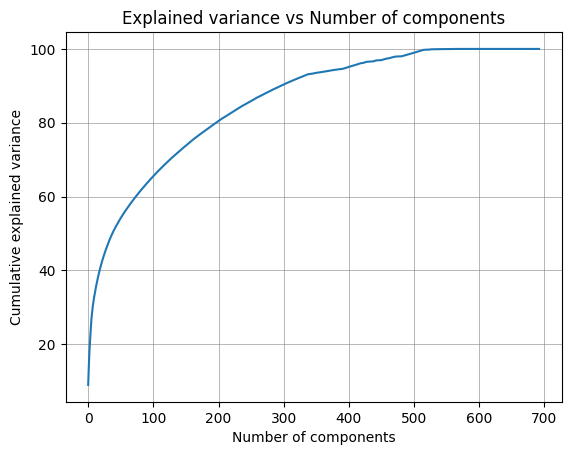

In [ ]:
plt.title("Explained variance vs Number of components")

plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.grid(color='gray', linewidth=.4)

plt.plot(range(len(cumulative_variance_explained)), cumulative_variance_explained)

plt.show()
#plt.savefig('Explained variance.png')

In [ ]:
K = 500
print('Principal components:', K)
print('Discarded components:', columns-K)

Principal components: 500
Discarded components: 193


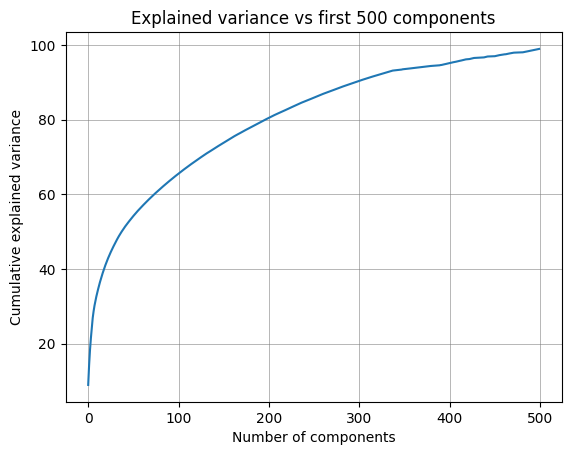

In [ ]:
plt.title("Explained variance vs first " + str(K) + " components")

plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.grid(color='gray', linewidth=.4)

plt.plot(range(K), cumulative_variance_explained[:K])

plt.show()
#plt.savefig('Explained variance.png')

In [ ]:
# Project using first K components

projection_matrix = np.real((eigen_vectors.T[:][:K]).T)
print(projection_matrix.shape)

np.save('projection_matrix', projection_matrix)
     

(693, 500)


In [ ]:
# project matrices
X_train = stdX.dot(projection_matrix)
X_val = stdX_val.dot(projection_matrix)
X_test = stdX_test.dot(projection_matrix)

In [ ]:
from tensorflow.keras import regularizers

class neural_network:
    def __init__(self):
        input = tensorflow.keras.Input(shape=(K,))
        
        dense = tensorflow.keras.layers.Dense(units=5, 
                                                activation='sigmoid',
                                                kernel_regularizer=regularizers.L1L2(l1=1e-3, l2=1e-3),
                                                bias_regularizer=regularizers.L2(1e-3),
                                                activity_regularizer=regularizers.L2(1e-3))(input)
        #norm = tensorflow.keras.layers.BatchNormalization()(dense)
        #drop = tensorflow.keras.layers.Dropout(.3)(dense)
        #dense = tensorflow.keras.layers.Dense(10, activation='sigmoid')(drop)
        output = tensorflow.keras.layers.Dense(1, activation='sigmoid')(dense)

        model = tensorflow.keras.models.Model(inputs=input, outputs=output)
        model.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics='accuracy')
        self.model = model

In [ ]:
nn = neural_network()

In [ ]:
nn.model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 500)]             0         
                                                                 
 dense (Dense)               (None, 5)                 2505      
                                                                 
 dense_1 (Dense)             (None, 1)                 6         
                                                                 
Total params: 2,511
Trainable params: 2,511
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = nn.model.fit(
    x=X_train, 
    y=y_train,
    batch_size=32,
    epochs=2000,
    verbose=1,
    validation_data=(X_val, y_val),
    shuffle=True,
    callbacks=[tensorflow.keras.callbacks.EarlyStopping(
    restore_best_weights=True,
    patience=10
        )]
)

Epoch 1/2000
114/114 [==============================] - 2s 8ms/step - loss: 0.8572 - accuracy: 0.4909 - val_loss: 0.7793 - val_accuracy: 0.5686
Epoch 2/2000
114/114 [==============================] - 0s 4ms/step - loss: 0.7403 - accuracy: 0.5967 - val_loss: 0.6907 - val_accuracy: 0.6881
Epoch 3/2000
114/114 [==============================] - 0s 4ms/step - loss: 0.6621 - accuracy: 0.7630 - val_loss: 0.6258 - val_accuracy: 0.8097
Epoch 4/2000
114/114 [==============================] - 1s 4ms/step - loss: 0.6032 - accuracy: 0.8320 - val_loss: 0.5726 - val_accuracy: 0.8363
Epoch 5/2000
114/114 [==============================] - 0s 3ms/step - loss: 0.5561 - accuracy: 0.8522 - val_loss: 0.5310 - val_accuracy: 0.8562
Epoch 6/2000
114/114 [==============================] - 0s 3ms/step - loss: 0.5200 - accuracy: 0.8616 - val_loss: 0.4985 - val_accuracy: 0.8673
Epoch 7/2000
114/114 [==============================] - 0s 3ms/step - loss: 0.4920 - accuracy: 0.8627 - val_loss: 0.4736 - val_accuracy:

In [ ]:
test_loss, test_acc = nn.model.evaluate(X_test, y_test)
#wandb.log({'test_accuracy': test_acc})


15/15 [==============================] - 0s 3ms/step - loss: 0.3582 - accuracy: 0.8739


In [ ]:
from sklearn.metrics import confusion_matrix
import tensorflow as tf

predictions = nn.model.predict(X_test)

predicted_classes = np.round(predictions)
true_classes = y_test
cm = confusion_matrix(true_classes, predicted_classes)

15/15 [==============================] - 0s 2ms/step


In [ ]:
print(cm)

[[217  26]
 [ 31 178]]


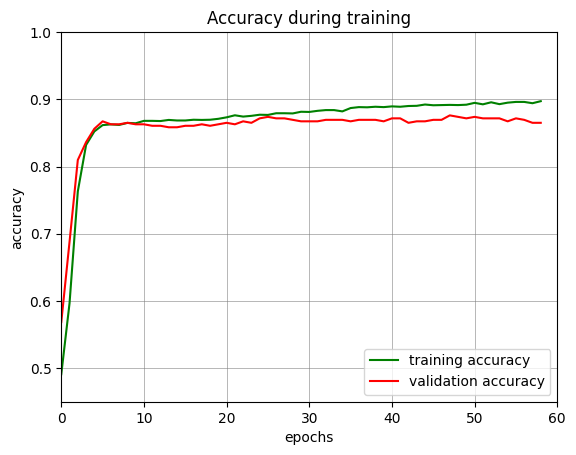

In [ ]:
plt.title('Accuracy during training')
plt.plot(range(len(history.history['loss'])), history.history['accuracy'], label='training accuracy', color='green')
plt.plot(range(len(history.history['loss'])), history.history['val_accuracy'], label='validation accuracy', color='red')
plt.grid(color='gray', linewidth=.4)

plt.legend(loc="lower right")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.xlim(0, len(history.history['loss'])+1)
plt.ylim(.45, 1.)
plt.savefig('acc.png')

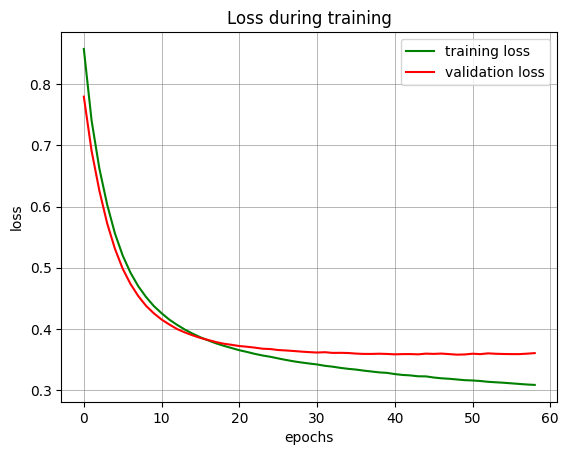

In [ ]:
plt.title('Loss during training')
plt.plot(range(len(history.history['loss'])), history.history['loss'], label='training loss', color='green')
plt.plot(range(len(history.history['loss'])), history.history['val_loss'], label='validation loss', color='red')
plt.grid(color='gray', linewidth=.4)

plt.legend(loc="upper right")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.savefig('loss.png')

In [ ]:
nn.model.evaluate(x=X_test, y=y_test)

15/15 [==============================] - 0s 2ms/step - loss: 0.3582 - accuracy: 0.8739


[0.35818731784820557, 0.8738937973976135]

In [ ]:
nn.model.save('ac.h5')

- BONUS: weight & biases (https://wandb.ai/site)

In [ ]:
import wandb
from wandb.keras import WandbCallback

class neural_network:
    config = {}

    def __init__(self):
        input = tensorflow.keras.Input(shape=(K,))
        
        dense = tensorflow.keras.layers.Dense(units=self.config['num_units'], 
                                              activation='sigmoid',
                                              kernel_regularizer=regularizers.L1L2(l1=self.config['l1_reg'], l2=self.config['l2_reg']),
                                              bias_regularizer=regularizers.L2(self.config['bias_reg']),
                                              activity_regularizer=regularizers.L2(self.config['activity_reg']))(input)
        #norm = tensorflow.keras.layers.BatchNormalization()(dense)
        #drop = tensorflow.keras.layers.Dropout(self.config['dropout_rate'])(dense)
        #dense = tensorflow.keras.layers.Dense(10, activation='sigmoid')(drop)
        output = tensorflow.keras.layers.Dense(1, activation='sigmoid')(dense)

        model = tensorflow.keras.models.Model(inputs=input, outputs=output)
        model.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=self.config['learning_rate']), loss='binary_crossentropy', metrics='accuracy')
        self.model = model           
        
    def train(self, X_train, y_train, X_val, y_val, X_test, y_test):
        history = self.model.fit(
            x=X_train, 
            y=y_train,
            batch_size=self.config['batch_size'],
            epochs=2000,
            verbose=1,
            validation_data=(X_val, y_val),
            shuffle=True,
            callbacks=[tensorflow.keras.callbacks.EarlyStopping(
                restore_best_weights=True,
                patience=10
            ), WandbCallback()]
        )
        
        test_loss, test_acc = self.model.evaluate(X_test, y_test)
        wandb.log({'test_accuracy': test_acc})

hyperparams = {
    'batch_size': 32,
    'learning_rate': 0.0005,
    'num_units': 5,
    'dropout_rate': 0.3,
    'l1_reg': 1e-3,
    'l2_reg': 1e-3,
    'bias_reg': 1e-3,
    'activity_reg': 1e-3
}

wandb.init(project='EUspaan', config=hyperparams)
neural_network.config = wandb.config

nn = neural_network()
nn.train(X_train, y_train, X_val, y_val, X_test, y_test)


accuracy,▁▄▇█
epoch,▁▃▆█
loss,█▅▃▁
val_accuracy,▁▅▇█
val_loss,█▅▃▁
accuracy,0.83402
best_epoch,3
best_val_loss,0.54289
epoch,3
loss,0.5369
val_accuracy,0.79515


Epoch 1/2000
 97/114 [========================>.....] - ETA: 0s - loss: 0.7935 - accuracy: 0.6008

wandb: Adding directory to artifact (/content/wandb/run-20230313_162842-od3innav/files/model-best)... Done. 0.0s


114/114 [==============================] - 2s 11ms/step - loss: 0.7860 - accuracy: 0.6124 - val_loss: 0.7276 - val_accuracy: 0.7004
Epoch 2/2000
107/114 [===========================>..] - ETA: 0s - loss: 0.6796 - accuracy: 0.7573

wandb: Adding directory to artifact (/content/wandb/run-20230313_162842-od3innav/files/model-best)... Done. 0.0s


114/114 [==============================] - 1s 12ms/step - loss: 0.6768 - accuracy: 0.7605 - val_loss: 0.6411 - val_accuracy: 0.7709
Epoch 3/2000
101/114 [=========================>....] - ETA: 0s - loss: 0.5988 - accuracy: 0.8270

wandb: Adding directory to artifact (/content/wandb/run-20230313_162842-od3innav/files/model-best)... Done. 0.0s


114/114 [==============================] - 1s 13ms/step - loss: 0.5949 - accuracy: 0.8315 - val_loss: 0.5776 - val_accuracy: 0.8084
Epoch 4/2000
 98/114 [========================>.....] - ETA: 0s - loss: 0.5355 - accuracy: 0.8520

wandb: Adding directory to artifact (/content/wandb/run-20230313_162842-od3innav/files/model-best)... Done. 0.0s


114/114 [==============================] - 1s 9ms/step - loss: 0.5347 - accuracy: 0.8486 - val_loss: 0.5331 - val_accuracy: 0.8172
Epoch 5/2000
 99/114 [=========================>....] - ETA: 0s - loss: 0.4976 - accuracy: 0.8472

wandb: Adding directory to artifact (/content/wandb/run-20230313_162842-od3innav/files/model-best)... Done. 0.0s


114/114 [==============================] - 1s 10ms/step - loss: 0.4921 - accuracy: 0.8514 - val_loss: 0.5028 - val_accuracy: 0.8260
Epoch 6/2000
 97/114 [========================>.....] - ETA: 0s - loss: 0.4655 - accuracy: 0.8605

wandb: Adding directory to artifact (/content/wandb/run-20230313_162842-od3innav/files/model-best)... Done. 0.0s


114/114 [==============================] - 1s 8ms/step - loss: 0.4623 - accuracy: 0.8624 - val_loss: 0.4815 - val_accuracy: 0.8326
Epoch 7/2000
 97/114 [========================>.....] - ETA: 0s - loss: 0.4442 - accuracy: 0.8621

wandb: Adding directory to artifact (/content/wandb/run-20230313_162842-od3innav/files/model-best)... Done. 0.0s


114/114 [==============================] - 1s 12ms/step - loss: 0.4410 - accuracy: 0.8643 - val_loss: 0.4662 - val_accuracy: 0.8326
Epoch 8/2000
 92/114 [=======================>......] - ETA: 0s - loss: 0.4230 - accuracy: 0.8668

wandb: Adding directory to artifact (/content/wandb/run-20230313_162842-od3innav/files/model-best)... Done. 0.0s


114/114 [==============================] - 1s 8ms/step - loss: 0.4249 - accuracy: 0.8654 - val_loss: 0.4548 - val_accuracy: 0.8326
Epoch 9/2000
110/114 [===========================>..] - ETA: 0s - loss: 0.4112 - accuracy: 0.8679

wandb: Adding directory to artifact (/content/wandb/run-20230313_162842-od3innav/files/model-best)... Done. 0.0s


114/114 [==============================] - 1s 8ms/step - loss: 0.4125 - accuracy: 0.8665 - val_loss: 0.4466 - val_accuracy: 0.8326
Epoch 10/2000
 90/114 [======================>.......] - ETA: 0s - loss: 0.4041 - accuracy: 0.8653

wandb: Adding directory to artifact (/content/wandb/run-20230313_162842-od3innav/files/model-best)... Done. 0.0s


114/114 [==============================] - 1s 9ms/step - loss: 0.4026 - accuracy: 0.8676 - val_loss: 0.4400 - val_accuracy: 0.8348
Epoch 11/2000
 93/114 [=======================>......] - ETA: 0s - loss: 0.3909 - accuracy: 0.8679

wandb: Adding directory to artifact (/content/wandb/run-20230313_162842-od3innav/files/model-best)... Done. 0.0s


114/114 [==============================] - 1s 9ms/step - loss: 0.3943 - accuracy: 0.8682 - val_loss: 0.4349 - val_accuracy: 0.8326
Epoch 12/2000
 97/114 [========================>.....] - ETA: 0s - loss: 0.3891 - accuracy: 0.8718

wandb: Adding directory to artifact (/content/wandb/run-20230313_162842-od3innav/files/model-best)... Done. 0.0s


114/114 [==============================] - 1s 8ms/step - loss: 0.3872 - accuracy: 0.8706 - val_loss: 0.4309 - val_accuracy: 0.8370
Epoch 13/2000
 90/114 [======================>.......] - ETA: 0s - loss: 0.3837 - accuracy: 0.8687

wandb: Adding directory to artifact (/content/wandb/run-20230313_162842-od3innav/files/model-best)... Done. 0.0s


114/114 [==============================] - 1s 10ms/step - loss: 0.3813 - accuracy: 0.8706 - val_loss: 0.4285 - val_accuracy: 0.8304
Epoch 14/2000
101/114 [=========================>....] - ETA: 0s - loss: 0.3744 - accuracy: 0.8744

wandb: Adding directory to artifact (/content/wandb/run-20230313_162842-od3innav/files/model-best)... Done. 0.0s


114/114 [==============================] - 1s 12ms/step - loss: 0.3759 - accuracy: 0.8712 - val_loss: 0.4257 - val_accuracy: 0.8326
Epoch 15/2000
108/114 [===========================>..] - ETA: 0s - loss: 0.3703 - accuracy: 0.8747

wandb: Adding directory to artifact (/content/wandb/run-20230313_162842-od3innav/files/model-best)... Done. 0.0s


114/114 [==============================] - 1s 11ms/step - loss: 0.3713 - accuracy: 0.8745 - val_loss: 0.4244 - val_accuracy: 0.8282
Epoch 16/2000
112/114 [============================>.] - ETA: 0s - loss: 0.3664 - accuracy: 0.8756

wandb: Adding directory to artifact (/content/wandb/run-20230313_162842-od3innav/files/model-best)... Done. 0.0s


114/114 [==============================] - 1s 8ms/step - loss: 0.3669 - accuracy: 0.8756 - val_loss: 0.4222 - val_accuracy: 0.8260
Epoch 17/2000
109/114 [===========================>..] - ETA: 0s - loss: 0.3636 - accuracy: 0.8764

wandb: Adding directory to artifact (/content/wandb/run-20230313_162842-od3innav/files/model-best)... Done. 0.0s


114/114 [==============================] - 1s 9ms/step - loss: 0.3629 - accuracy: 0.8764 - val_loss: 0.4216 - val_accuracy: 0.8304
Epoch 18/2000
111/114 [============================>.] - ETA: 0s - loss: 0.3576 - accuracy: 0.8784

wandb: Adding directory to artifact (/content/wandb/run-20230313_162842-od3innav/files/model-best)... Done. 0.0s


114/114 [==============================] - 1s 9ms/step - loss: 0.3594 - accuracy: 0.8775 - val_loss: 0.4206 - val_accuracy: 0.8282
Epoch 19/2000
 91/114 [======================>.......] - ETA: 0s - loss: 0.3555 - accuracy: 0.8808

wandb: Adding directory to artifact (/content/wandb/run-20230313_162842-od3innav/files/model-best)... Done. 0.0s


114/114 [==============================] - 1s 11ms/step - loss: 0.3563 - accuracy: 0.8803 - val_loss: 0.4198 - val_accuracy: 0.8304
Epoch 20/2000
111/114 [============================>.] - ETA: 0s - loss: 0.3552 - accuracy: 0.8812

wandb: Adding directory to artifact (/content/wandb/run-20230313_162842-od3innav/files/model-best)... Done. 0.0s


114/114 [==============================] - 1s 9ms/step - loss: 0.3534 - accuracy: 0.8816 - val_loss: 0.4194 - val_accuracy: 0.8326
Epoch 21/2000
103/114 [==========================>...] - ETA: 0s - loss: 0.3498 - accuracy: 0.8796

wandb: Adding directory to artifact (/content/wandb/run-20230313_162842-od3innav/files/model-best)... Done. 0.0s


114/114 [==============================] - 1s 9ms/step - loss: 0.3507 - accuracy: 0.8797 - val_loss: 0.4192 - val_accuracy: 0.8348
Epoch 22/2000
104/114 [==========================>...] - ETA: 0s - loss: 0.3488 - accuracy: 0.8804

wandb: Adding directory to artifact (/content/wandb/run-20230313_162842-od3innav/files/model-best)... Done. 0.0s


114/114 [==============================] - 1s 9ms/step - loss: 0.3481 - accuracy: 0.8822 - val_loss: 0.4184 - val_accuracy: 0.8348
Epoch 23/2000
114/114 [==============================] - 0s 2ms/step - loss: 0.3455 - accuracy: 0.8825 - val_loss: 0.4185 - val_accuracy: 0.8326
Epoch 24/2000
 96/114 [========================>.....] - ETA: 0s - loss: 0.3473 - accuracy: 0.8828

wandb: Adding directory to artifact (/content/wandb/run-20230313_162842-od3innav/files/model-best)... Done. 0.0s


114/114 [==============================] - 1s 9ms/step - loss: 0.3433 - accuracy: 0.8852 - val_loss: 0.4172 - val_accuracy: 0.8304
Epoch 25/2000
114/114 [==============================] - 0s 3ms/step - loss: 0.3411 - accuracy: 0.8860 - val_loss: 0.4185 - val_accuracy: 0.8326
Epoch 26/2000
114/114 [==============================] - 0s 2ms/step - loss: 0.3392 - accuracy: 0.8863 - val_loss: 0.4181 - val_accuracy: 0.8304
Epoch 27/2000
114/114 [==============================] - 0s 2ms/step - loss: 0.3374 - accuracy: 0.8860 - val_loss: 0.4180 - val_accuracy: 0.8260
Epoch 28/2000
114/114 [==============================] - 0s 4ms/step - loss: 0.3354 - accuracy: 0.8899 - val_loss: 0.4184 - val_accuracy: 0.8238
Epoch 29/2000
114/114 [==============================] - 0s 3ms/step - loss: 0.3339 - accuracy: 0.8893 - val_loss: 0.4178 - val_accuracy: 0.8260
Epoch 30/2000
114/114 [==============================] - 0s 3ms/step - loss: 0.3324 - accuracy: 0.8888 - val_loss: 0.4182 - val_accuracy: 0.8238

In [ ]:
import wandb
from wandb.keras import WandbCallback
import random

class neural_network:
    def __init__(self, config):
        input = tensorflow.keras.Input(shape=(K,))
        
        dense = tensorflow.keras.layers.Dense(units=config['num_units'], 
                                              activation='sigmoid',
                                              kernel_regularizer=regularizers.L1L2(l1=config['l1_reg'], l2=config['l2_reg']),
                                              bias_regularizer=regularizers.L2(config['bias_reg']),
                                              activity_regularizer=regularizers.L2(config['activity_reg']))(input)
        #norm = tensorflow.keras.layers.BatchNormalization()(dense)
        #drop = tensorflow.keras.layers.Dropout(config['dropout_rate'])(dense)
        #dense = tensorflow.keras.layers.Dense(10, activation='sigmoid')(drop)
        output = tensorflow.keras.layers.Dense(1, activation='sigmoid')(dense)

        model = tensorflow.keras.models.Model(inputs=input, outputs=output)
        model.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=config['learning_rate']), loss='binary_crossentropy', metrics='accuracy')
        self.model = model           
        
    def train(self, X_train, y_train, X_val, y_val, X_test, y_test):
        history = self.model.fit(
            x=X_train, 
            y=y_train,
            batch_size=config['batch_size'],
            epochs=2000,
            verbose=1,
            validation_data=(X_val, y_val),
            shuffle=True,
            callbacks=[tensorflow.keras.callbacks.EarlyStopping(
                restore_best_weights=True,
                patience=10
            ), WandbCallback()]
        )
        
        test_loss, test_acc = self.model.evaluate(X_test, y_test)
        wandb.log({'test_accuracy': test_acc})

def random_hyperparams():
    return {
        'batch_size': random.choice([32, 64 , 128]),
        'learning_rate': random.uniform(0.0001, 0.01),
        'num_units': random.randint(3, 100),
        'dropout_rate': random.uniform(0, 0.8),
        'l1_reg': random.uniform(0, 0.01),
        'l2_reg': random.uniform(0, 0.01),
        'bias_reg': random.uniform(0, 0.01),
        'activity_reg': random.uniform(0, 0.01)
    }

wandb.init(project='uncategorizedh')

for i in range(100):
    config = random_hyperparams()
    with wandb.init(project='uncategorized', config=config):
        nn = neural_network(config)
        nn.train(X_train, y_train, X_val, y_val, X_test, y_test)
